In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1337)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 40
#nb_classes = 10
nb_epoch = 100

# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# Training data, shuffled and split
WB = np.array(sio.loadmat('sandstone_data.mat')['Data'])
Y_data = np.array(sio.loadmat('sandstone_data.mat')['L'])
# Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))
X_train = X_data[:720]
X_val = X_data[720:]

WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
# Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


#normalize label all together to be consistent
label_norm = np.concatenate((Y_data, Y_test), axis=0)
label_norm = (label_norm-min(label_norm))/(max(label_norm)-min(label_norm))
Y_train = label_norm[:720]
Y_val = label_norm[720:-240]
Y_test = label_norm[-240:]


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (720, 128, 128, 1)
720 train samples
48 validate samples
240 test samples


In [6]:
# CNN

model = Sequential()

model.add(Convolution2D(24, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(24, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(48, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('relu'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [11]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
model.fit(X_train, Y_train, batch_size=40, epochs=20, verbose=1, validation_data=(X_val, Y_val), 
          callbacks=[early_stop])

Train on 720 samples, validate on 48 samples
Epoch 1/20
720/720 [==============================] - 65s - loss: 0.0034 - mean_absolute_error: 0.0416 - val_loss: 0.0012 - val_mean_absolute_error: 0.0306
Epoch 2/20
720/720 [==============================] - 57s - loss: 0.0032 - mean_absolute_error: 0.0410 - val_loss: 2.4148e-04 - val_mean_absolute_error: 0.0117
Epoch 3/20
720/720 [==============================] - 62s - loss: 0.0032 - mean_absolute_error: 0.0407 - val_loss: 2.7244e-04 - val_mean_absolute_error: 0.0127
Epoch 4/20
720/720 [==============================] - 69s - loss: 0.0027 - mean_absolute_error: 0.0385 - val_loss: 4.1002e-04 - val_mean_absolute_error: 0.0173
Epoch 5/20
720/720 [==============================] - 83s - loss: 0.0036 - mean_absolute_error: 0.0433 - val_loss: 0.0035 - val_mean_absolute_error: 0.0533
Epoch 6/20
720/720 [==============================] - 69s - loss: 0.0028 - mean_absolute_error: 0.0384 - val_loss: 0.0014 - val_mean_absolute_error: 0.0330
Epoch 7

KeyboardInterrupt: 

training mse: 0.000626916978571
testing mse: 0.002560406593


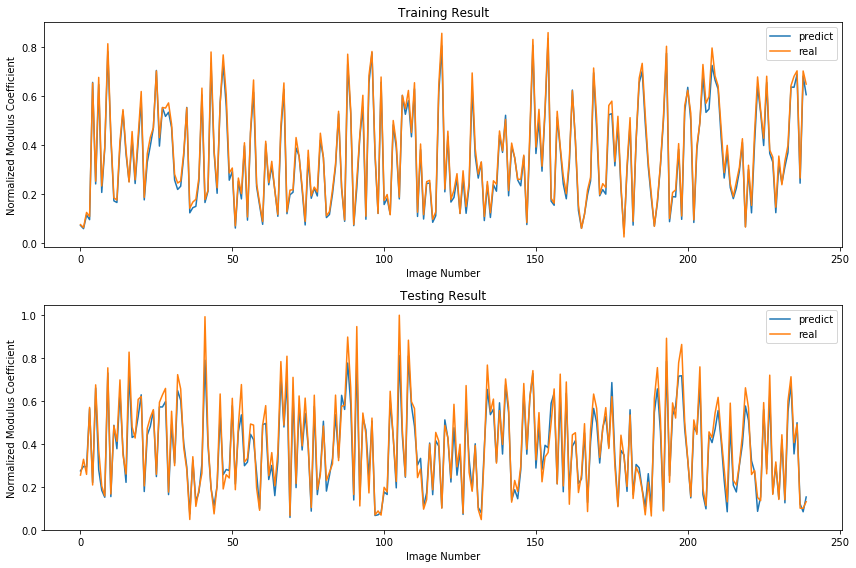

In [12]:
x=[]
num = 240
for i in range(num):
    x.append(i)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)

train_pred=model.predict(X_train)
print('training mse:', mean_squared_error(Y_train, train_pred))

ax1.plot(x,train_pred[0:num], label='predict')
ax1.plot(x,Y_train[0:num],label='real')
plt.legend()
ax1.set_title('Training Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')


ax2=fig.add_subplot(2,1,2)

test_pred=model.predict(X_test)
print('testing mse:', mean_squared_error(Y_test, test_pred))

ax2.plot(x,test_pred[0:num], label='predict')
ax2.plot(x,Y_test[0:num],label='real')
plt.legend()
ax2.set_title('Testing Result')
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Normalized Modulus Coefficient')

plt.tight_layout()
plt.savefig('original.png',dpi=400)
# plt.savefig('prediction_result_2.png',dpi=400)

In [13]:
#model = load_model('CNN_model_original_081217.h5')

IOError: Unable to open file (Unable to open file: name = 'cnn_model_original_081217.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [22]:
np.where(Y_test == 0)[0]

Y_test[132]

"""
se = (test_pred - Y_test)/Y_test
count = 0
for i in range(240):
    if np.abs(se[i])>=0.3:
        count += 1
        
count
"""

array([ 0.])

In [30]:
threshold = 0.3
def find_image_nb(Input):
    image_nb = []
    for i in range(len(Input)):
        if abs(Input[i]) >= threshold:
            image_nb.append(i)
            
    return image_nb

In [32]:
image_nb = find_image_nb(se)
diff_test = X_test[image_nb]

In [21]:
# np.size(image_nb)
image_nb[4]

7

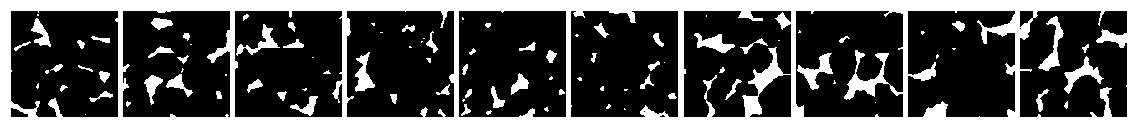

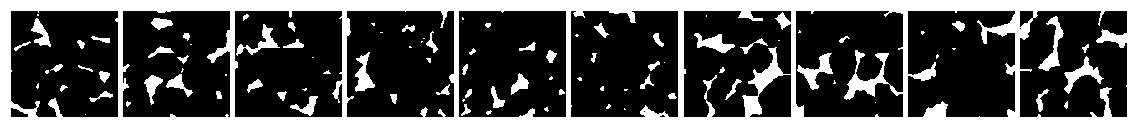

In [34]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10,10))

'''
ax1=fig.add_subplot(1,2,1)
plt.axis('off')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.imshow(X_test[7].reshape(128,128))

ax1=fig.add_subplot(1,2,2)
plt.axis('off')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.imshow(diff_test[4].reshape(128,128))
'''

def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

plot(X_test[image_nb[:10]])
plot(diff_test[:10])

In [35]:
diff_test.shape
# np.size(image_nb)

(110, 128, 128, 1)

In [ ]:
diff_test = diff_test[:90]
image_nb = image_nb[:90]
sio.savemat('diff_fig.mat',{'img':diff_test, 'index':image_nb})

In [24]:
model.evaluate(X_test, Y_test, batch_size=40)

240/240 [==============================] - 0s     


[0.0042388046470781164, 0.0042388046470781164]

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 24)      888       
_________________________________________________________________
activation_24 (Activation)   (None, 128, 128, 24)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 48)        10416     
_________________________________________________________________
activation_25 (Activation)   (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 96)        41568     
__________

In [14]:
model.save('CNN_original_model_081217.h5')